In [1]:
%matplotlib inline
!pip install imblearn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, make_scorer

pd.set_option('display.max_columns',25)  # to show all the columns while printing the df
pd.set_option('display.max_rows',25)  # to show all the rows while printing the df

### Load the data

In [2]:
data = pd.read_csv("YourCabs.csv")
data.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


### Verify the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  online_booking       43431 non-null  int64  
 11  mobile_site_booking  43431 non-null  int64  
 12  booking_created      43431 non-null  object 
 13  from_lat             43338 non-null  float64
 14  from_long            43338 non-null  float64
 15  to_lat               34293 non-null 

### Dropping columns having unique values and PII


In [4]:
data=data.drop(['id','user_id'],axis=1)

### Filtering out travel_type_id=1

In [5]:
# This refers to Intercity (Long distance) travel, where the destination is optional.
data_tt1 = data[data['travel_type_id'] == 1] # filtering the data having travel_type_id 1
data_tt1.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
6,12,NaN,1,571.0,NaN,15.0,108.0,01-01-2013 09:45,0,0,01-01-2013 09:21,12.951850,77.696420,NaN,NaN,0
17,24,NaN,1,1383.0,NaN,NaN,32.0,01-12-2013 08:00,1,0,01-01-2013 12:17,12.930451,77.685822,NaN,NaN,0
24,54,NaN,1,515.0,NaN,15.0,32.0,01-05-2013 08:30,0,0,01-01-2013 14:40,12.978960,77.673450,NaN,NaN,0
158,28,NaN,1,136.0,NaN,1.0,152.0,01-04-2013 09:30,1,0,01-03-2013 12:19,12.907960,77.624180,NaN,NaN,0
216,87,NaN,1,1118.0,NaN,NaN,32.0,01-06-2013 07:30,1,0,01-04-2013 09:32,12.930220,77.560390,NaN,NaN,0


### Dropping travel_type_id which is no more required

In [6]:
data_tt1 = data_tt1.drop(['travel_type_id'],axis=1)

### Checking missing values

In [7]:
data_tt1.isnull().sum()

vehicle_model_id          0
package_id             1589
from_area_id             88
to_area_id             1588
from_city_id            196
to_city_id                1
from_date                 0
online_booking            0
mobile_site_booking       0
booking_created           0
from_lat                 93
from_long                93
to_lat                 1588
to_long                1588
Car_Cancellation          0
dtype: int64

### Treating missing values

In [8]:
# from_city_id and to_city_id are categorical values, so filling it with mode
data_tt1['from_city_id'].fillna(int(data_tt1['from_city_id'].mode()), inplace=True)
data_tt1['to_city_id'].fillna(int(data_tt1['to_city_id'].mode()), inplace=True)
data_tt1['from_area_id'].fillna(int(data_tt1['from_city_id'].mode()), inplace=True)

### Analysing data proportion in categorical variables

In [9]:
data_tt1['vehicle_model_id'].value_counts(normalize=True)*100

12    46.192574
65    22.970422
87     9.943361
89     5.852738
54     4.531152
85     3.587162
24     2.957835
28     2.139711
13     0.440529
10     0.377596
23     0.251731
36     0.188798
90     0.188798
86     0.125865
69     0.062933
14     0.062933
70     0.062933
30     0.062933
Name: vehicle_model_id, dtype: float64

In [10]:
data_tt1['package_id'].value_counts(normalize=True)*100

Series([], Name: package_id, dtype: float64)

In [11]:
data_tt1['from_area_id'].value_counts(normalize=True)*100

393.0     16.173694
571.0      6.167401
15.0       5.538074
585.0      2.957835
142.0      2.769037
            ...    
492.0      0.062933
376.0      0.062933
1358.0     0.062933
1395.0     0.062933
1062.0     0.062933
Name: from_area_id, Length: 298, dtype: float64

In [12]:
data_tt1['to_area_id'].value_counts(normalize=True)*100

1080.0    100.0
Name: to_area_id, dtype: float64

In [13]:
data_tt1['from_city_id'].value_counts(normalize=True)*100

15.0    92.951542
1.0      6.670862
31.0     0.377596
Name: from_city_id, dtype: float64

In [14]:
data_tt1['to_city_id'].value_counts(normalize=True)*100

32.0     29.955947
55.0     10.950283
29.0      7.300189
146.0     5.601007
108.0     4.027690
           ...    
169.0     0.062933
139.0     0.062933
94.0      0.062933
23.0      0.062933
50.0      0.062933
Name: to_city_id, Length: 116, dtype: float64

In [15]:
data_tt1['online_booking'].value_counts(normalize=True)*100

0    57.268722
1    42.731278
Name: online_booking, dtype: float64

In [16]:
data_tt1['mobile_site_booking'].value_counts(normalize=True)*100

0    98.11202
1     1.88798
Name: mobile_site_booking, dtype: float64

### Data Cleaning 

In [17]:
### Delete the below columns due to:
### vehicle_model_id - improportionate data, leads to bias
### package_id - not required for travel_type_id = 1
### to_area_id - improportionate and also not mandatory for travel_type_id = 1
### from_city_id - improportionate data, leads to bias
### mobile_site_booking - improportionate data, leads to bias
### from_long, from_lat - same information as in from_area_id
### to_lat, to_long - not mandatory for travel_type_id =1, so, it has more null values


data_tt1 = data_tt1.drop(['vehicle_model_id','package_id','mobile_site_booking','to_area_id','from_lat','from_long','to_lat','to_long'],axis=1) # dropping columns not relevant to travel_type_id 1
data_tt1.head()

,from_area_id,from_city_id,to_city_id,from_date,online_booking,booking_created,Car_Cancellation
6,571.0,15.0,108.0,01-01-2013 09:45,0,01-01-2013 09:21,0
17,1383.0,15.0,32.0,01-12-2013 08:00,1,01-01-2013 12:17,0
24,515.0,15.0,32.0,01-05-2013 08:30,0,01-01-2013 14:40,0
158,136.0,1.0,152.0,01-04-2013 09:30,1,01-03-2013 12:19,0
216,1118.0,15.0,32.0,01-06-2013 07:30,1,01-04-2013 09:32,0


### Treating and extracting info from Date columns

In [18]:
data_tt1['from_date_treated'] = pd.to_datetime(data_tt1['from_date'])
data_tt1['booking_date_treated'] = pd.to_datetime(data_tt1['booking_created'])
data_tt1.head()

,from_area_id,from_city_id,to_city_id,from_date,online_booking,booking_created,Car_Cancellation,from_date_treated,booking_date_treated
6,571.0,15.0,108.0,01-01-2013 09:45,0,01-01-2013 09:21,0,2013-01-01 09:45:00,2013-01-01 09:21:00
17,1383.0,15.0,32.0,01-12-2013 08:00,1,01-01-2013 12:17,0,2013-01-12 08:00:00,2013-01-01 12:17:00
24,515.0,15.0,32.0,01-05-2013 08:30,0,01-01-2013 14:40,0,2013-01-05 08:30:00,2013-01-01 14:40:00
158,136.0,1.0,152.0,01-04-2013 09:30,1,01-03-2013 12:19,0,2013-01-04 09:30:00,2013-01-03 12:19:00
216,1118.0,15.0,32.0,01-06-2013 07:30,1,01-04-2013 09:32,0,2013-01-06 07:30:00,2013-01-04 09:32:00


In [19]:
# After extracting required info in required format from date columns dropping the actual date columns in the data
data_tt1=data_tt1.drop(['from_date','booking_created'],axis=1)

#### Creating new columns from given date columns

In [20]:
data_tt1['waiting_period_min'] = (data_tt1['from_date_treated'] - data_tt1['booking_date_treated']).astype('timedelta64[m]') #new column waiting_period_min

data_tt1['travel_day'] = pd.to_datetime(data_tt1['from_date_treated']).dt.dayofweek #new column travel_day
data_tt1['travel_month'] = pd.to_datetime(data_tt1['from_date_treated']).dt.month #new column travel_month
data_tt1['booked_day'] = pd.to_datetime(data_tt1['booking_date_treated']).dt.dayofweek #new column booked_day
data_tt1['booked_month'] = pd.to_datetime(data_tt1['booking_date_treated']).dt.month #new column booked_month

cond = [(pd.to_datetime(data_tt1['from_date_treated']).dt.hour.between(5, 8)),
        (pd.to_datetime(data_tt1['from_date_treated']).dt.hour.between(9, 12)),
        (pd.to_datetime(data_tt1['from_date_treated']).dt.hour.between(13, 16)),
        (pd.to_datetime(data_tt1['from_date_treated']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data_tt1['from_date_treated']).dt.hour.between(21, 24)) | (pd.to_datetime(data_tt1['from_date_treated']).dt.hour==0)),
        (pd.to_datetime(data_tt1['from_date_treated']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']

data_tt1['travel_hour'] = np.select(cond,values) #new column travel_hour


cond = [(pd.to_datetime(data_tt1['booking_date_treated']).dt.hour.between(5, 8)),
        (pd.to_datetime(data_tt1['booking_date_treated']).dt.hour.between(9, 12)),
        (pd.to_datetime(data_tt1['booking_date_treated']).dt.hour.between(13, 16)),
        (pd.to_datetime(data_tt1['booking_date_treated']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data_tt1['booking_date_treated']).dt.hour.between(21, 24)) | (pd.to_datetime(data_tt1['booking_date_treated']).dt.hour==0)),
        (pd.to_datetime(data_tt1['booking_date_treated']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']

data_tt1['booked_hour'] = np.select(cond,values) #new column booked_hour

data_tt1.head()

,from_area_id,from_city_id,to_city_id,online_booking,Car_Cancellation,from_date_treated,booking_date_treated,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
6,571.0,15.0,108.0,0,0,2013-01-01 09:45:00,2013-01-01 09:21:00,24.0,1,1,1,1,Morning,Morning
17,1383.0,15.0,32.0,1,0,2013-01-12 08:00:00,2013-01-01 12:17:00,15583.0,5,1,1,1,Early Morning,Morning
24,515.0,15.0,32.0,0,0,2013-01-05 08:30:00,2013-01-01 14:40:00,5390.0,5,1,1,1,Early Morning,Afternoon
158,136.0,1.0,152.0,1,0,2013-01-04 09:30:00,2013-01-03 12:19:00,1271.0,4,1,3,1,Morning,Morning
216,1118.0,15.0,32.0,1,0,2013-01-06 07:30:00,2013-01-04 09:32:00,2758.0,6,1,4,1,Early Morning,Morning


### Checking missing values in the newly created columns

In [21]:
data_tt1.isnull().sum()

from_area_id            0
from_city_id            0
to_city_id              0
online_booking          0
Car_Cancellation        0
from_date_treated       0
booking_date_treated    0
waiting_period_min      0
travel_day              0
travel_month            0
booked_day              0
booked_month            0
travel_hour             0
booked_hour             0
dtype: int64

### Drop date and coordinates cols

In [22]:
### Now that required info has been extracted from date, lat, long columns and new cols created, those cols can be deleted
data_tt1=data_tt1.drop(['from_date_treated','booking_date_treated'],axis=1)

### Analysing data proportion in newly created categorical variables

In [23]:
data_tt1['travel_month'].value_counts(normalize=True)*100

10    13.467590
6     11.453744
8     10.950283
5     10.887351
9     10.069226
7      9.125236
4      8.936438
11     8.118313
3      6.859660
1      5.475142
2      4.468219
12     0.188798
Name: travel_month, dtype: float64

In [24]:
data_tt1['booked_month'].value_counts(normalize=True)*100

10    14.222782
6     10.950283
8     10.824418
5     10.572687
9     10.132159
4      9.628697
7      9.565765
3      6.859660
11     6.859660
1      5.789805
2      4.594084
Name: booked_month, dtype: float64

In [25]:
data_tt1['booked_day'].value_counts(normalize=True)*100

4    21.334172
5    19.257395
3    14.663310
2    11.453744
1    11.264947
6    11.202014
0    10.824418
Name: booked_day, dtype: float64

In [26]:
data_tt1['travel_day'].value_counts(normalize=True)*100

5    29.200755
6    20.767778
4    15.670233
3     9.754563
0     9.251101
2     8.244179
1     7.111391
Name: travel_day, dtype: float64

In [27]:
data_tt1['travel_hour'].value_counts(normalize=True)*100

Early Morning    54.310887
Morning          15.670233
Late Night       10.258024
Night             8.747640
Afternoon         6.167401
Evening           4.845815
Name: travel_hour, dtype: float64

In [28]:
data_tt1['booked_hour'].value_counts(normalize=True)*100

Evening          27.186910
Afternoon        25.928257
Morning          20.830711
Night            17.369415
Early Morning     5.789805
Late Night        2.894902
Name: booked_hour, dtype: float64

### Looking for outliers if any in newly created conitnuous variable columns

In [29]:
def find_outliers_IQR(df):  ### function to find outliers using IQR method
    LL,UL = find_LL_UL(df)
    outliers = df[((df < LL) | (df > UL))]
    return outliers

def find_LL_UL(df):         ### function to find lower limit and upper limit values in the given data using IQR method
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    LL = q1 - 1.5 * IQR
    UL = q3 + 1.5 * IQR
    return (LL,UL)

##### outliers in waiting_period_min

<Axes: xlabel='waiting_period_min'>

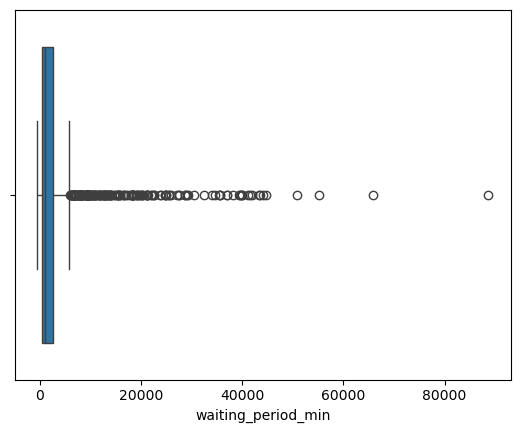

In [30]:
sns.boxplot(x='waiting_period_min', data=data_tt1) ### Before treatment

In [31]:
### Find the percentage of outliers in waiting_period_min column
outliers = find_outliers_IQR(data_tt1['waiting_period_min'])
print("Number of Outliers in Waiting Period : ",outliers.shape[0])
print("Percentage of outliers in Waiting Period : ", (outliers.shape[0]/data_tt1.shape[0])*100)

Number of Outliers in Waiting Period :  219
Percentage of outliers in Waiting Period :  13.782252989301448


In [32]:
### Negative values in waiting_period_min are due to wrong data in from_date and booked_date, so dropping the respective data
print("Negative values in waiting_period_min - Before treatment : ",(data_tt1['waiting_period_min'] < 0).value_counts())
data_tt1.drop(data_tt1[data_tt1['waiting_period_min']<0].index,axis=0,inplace=True)

print("Negative values in waiting_period_min - After treatment : ",(data_tt1['waiting_period_min'] < 0).value_counts())

Negative values in waiting_period_min - Before treatment :  False    1586
True        3
Name: waiting_period_min, dtype: int64
Negative values in waiting_period_min - After treatment :  False    1586
Name: waiting_period_min, dtype: int64


In [33]:
##### outlier treatment for waiting_period_min

In [34]:
### print("Outliers in waiting_period_min on the lower end before treatment: ",(data_tt1['waiting_period_min'] < 0).value_counts())

### LL,UL = find_LL_UL(data_tt1['waiting_period_min'])
### print("Outliers in waiting_period_min on the higher end before treatment: ",(data_tt1['waiting_period_min'] > UL).value_counts())

In [35]:
### Negative values in waiting_period_min are due to wrong data in from_date and booked_date, so dropping the respective data
### data_tt1.drop(data_tt1[data_tt1['waiting_period_min']<0].index,axis=0,inplace=True)
### print("Outliers in waiting_period_min on the lower end after treatment: ",(data_tt1['waiting_period_min'] < 0).value_counts()) ### Outliers on the lower end after treatment

In [36]:
### Outliers in waiting_period_min on the higher side more than 13%, so splitting data into with outliers and without outliers
### to build 2 models
### LL,UL = find_LL_UL(data_tt1['waiting_period_min'])
### data_tt1_wpol = data_tt1[data_tt1['waiting_period_min'] > UL] ### Data with outliers in waiting_period_min
### data_tt1 = data_tt1.drop(data_tt1[data_tt1['waiting_period_min']>UL].index,axis=0,inplace=True) ### Removing the outliers to get data without outliers in waiting_period_min


In [37]:
### sns.boxplot(data_tt1['waiting_period_min']) #After treatment

###### NOTE : Outliers for the remaining data in waiting_period_min would appear iteratively, so transformation and normalisation of the data is required rather to treat outliers

### Transformation of waiting_period_min using cbrt

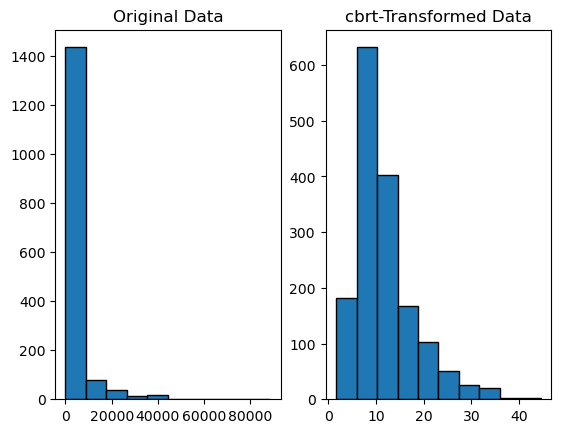

In [38]:
data = data_tt1['waiting_period_min']

# Perform cbrt transformation
data_log = np.cbrt(data)

# Create side-by-side histograms
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')
axs[0].set_title('Original Data')
axs[1].set_title('cbrt-Transformed Data')
plt.show()

In [39]:
data_tt1['waiting_period_min'] = data_log ### replace actual data with transformed data

<Axes: xlabel='waiting_period_min'>

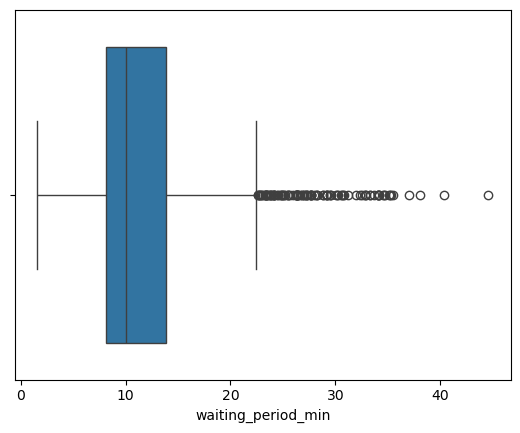

In [40]:
sns.boxplot(x='waiting_period_min', data=data_tt1) ### After transformation and before treatment

In [41]:
### Find the percentage of outliers in waiting_period_min column
outliers = find_outliers_IQR(data_tt1['waiting_period_min'])
print("Number of Outliers in Waiting Period : ",outliers.shape[0])
print("Percentage of outliers in Waiting Period : ", (outliers.shape[0]/data_tt1.shape[0])*100)

Number of Outliers in Waiting Period :  109
Percentage of outliers in Waiting Period :  6.872635561160151


###### Outliers in waiting_period_min are >5% but <10%. So, replacing it with respective limit values

In [42]:
### Percentage of outliers in the data is  less than 5%
### Outliers are only on the max side of the data, so replacing Outliers with Upper limit value

LL,UL = find_LL_UL(data_tt1['waiting_period_min'])
print("Lower limit and Upper limit values: ",LL,UL)

data_tt1.loc[data_tt1['waiting_period_min'] > UL,'waiting_period_min'] = UL

Lower limit and Upper limit values:  -0.4066151650351184 22.46982326695553


<Axes: xlabel='waiting_period_min'>

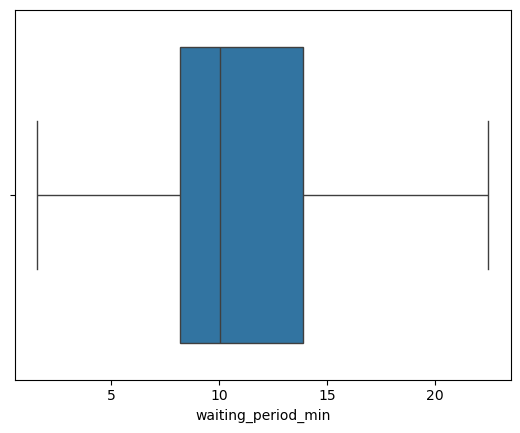

In [43]:
sns.boxplot(x='waiting_period_min', data=data_tt1) ### After transformation and after treatment

### Verify the pre processed data

In [44]:
data_tt1.shape

(1586, 12)

In [45]:
data_tt1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586 entries, 6 to 43407
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   from_area_id        1586 non-null   float64
 1   from_city_id        1586 non-null   float64
 2   to_city_id          1586 non-null   float64
 3   online_booking      1586 non-null   int64  
 4   Car_Cancellation    1586 non-null   int64  
 5   waiting_period_min  1586 non-null   float64
 6   travel_day          1586 non-null   int64  
 7   travel_month        1586 non-null   int64  
 8   booked_day          1586 non-null   int64  
 9   booked_month        1586 non-null   int64  
 10  travel_hour         1586 non-null   object 
 11  booked_hour         1586 non-null   object 
dtypes: float64(4), int64(6), object(2)
memory usage: 161.1+ KB


In [46]:
data_tt1.isnull().sum()

from_area_id          0
from_city_id          0
to_city_id            0
online_booking        0
Car_Cancellation      0
waiting_period_min    0
travel_day            0
travel_month          0
booked_day            0
booked_month          0
travel_hour           0
booked_hour           0
dtype: int64

In [47]:
data_tt1.head()

,from_area_id,from_city_id,to_city_id,online_booking,Car_Cancellation,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
6,571.0,15.0,108.0,0,0,2.884499,1,1,1,1,Morning,Morning
17,1383.0,15.0,32.0,1,0,22.469823,5,1,1,1,Early Morning,Morning
24,515.0,15.0,32.0,0,0,17.533270,5,1,1,1,Early Morning,Afternoon
158,136.0,1.0,152.0,1,0,10.832163,4,1,3,1,Morning,Morning
216,1118.0,15.0,32.0,1,0,14.023769,6,1,4,1,Early Morning,Morning


In [48]:
data_tt1.describe(include='object')

,travel_hour,booked_hour
count,1586,1586
unique,6,6
top,Early Morning,Evening
freq,860,432


### Label encoding

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data_tt1['travel_hour'] = le.fit_transform(data_tt1['travel_hour'])
data_tt1['booked_hour'] = le.fit_transform(data_tt1['booked_hour'])
data_tt1.head()

,from_area_id,from_city_id,to_city_id,online_booking,Car_Cancellation,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
6,571.0,15.0,108.0,0,0,2.884499,1,1,1,1,4,4
17,1383.0,15.0,32.0,1,0,22.469823,5,1,1,1,1,4
24,515.0,15.0,32.0,0,0,17.533270,5,1,1,1,1,0
158,136.0,1.0,152.0,1,0,10.832163,4,1,3,1,4,4
216,1118.0,15.0,32.0,1,0,14.023769,6,1,4,1,1,4


### Correlation Analysis

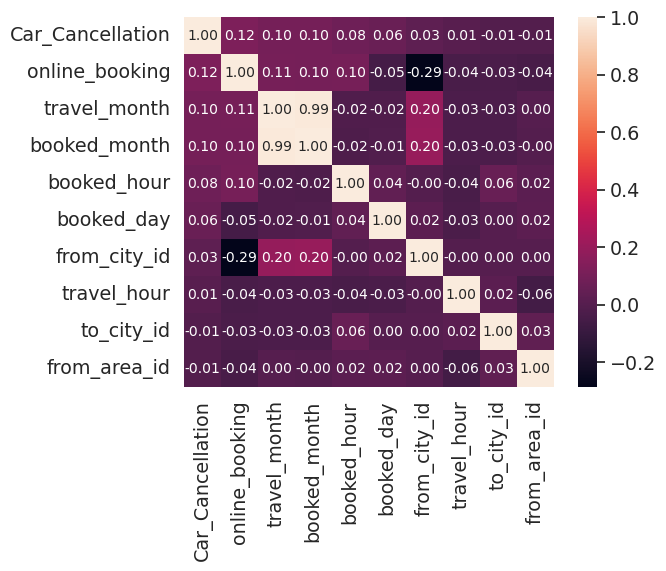

In [50]:
corrmat = data_tt1.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Car_Cancellation')['Car_Cancellation'].index
cm = np.corrcoef(data_tt1[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

###### NOTE : booked_month and travel_month are highly correlated, so dropping one of it (booked_month)

In [51]:
data_tt1 = data_tt1.drop(['booked_month'],axis=1)

### Extract features and target

In [52]:
x = data_tt1.iloc[:,data_tt1.columns != 'Car_Cancellation']
y = data_tt1.iloc[:,data_tt1.columns == 'Car_Cancellation']

In [53]:
x.shape

(1586, 10)

In [54]:
y.shape

(1586, 1)

### Scaling features before splitting

In [55]:
###Entire features scaling is required for some modelselections like KNN
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

x_copy=x
x_ss=ss.fit_transform(x_copy)

y_copy=y.values.ravel()

In [56]:
x.shape

(1586, 10)

In [57]:
y.shape

(1586, 1)

### Split data into training and test data

In [58]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.25,train_size=0.75,stratify=y)

In [59]:
xtrain.shape

(1189, 10)

In [60]:
ytrain.shape

(1189, 1)

In [61]:
unique, counts = np.unique(ytrain, return_counts=True)
result_dict = dict(zip(unique, counts))

result_dict

{0: 1173, 1: 16}

#### y_train has severe improportion in the data so using over sampling technique

In [62]:
np.random.seed(42)
#from imblearn.over_sampling import RandomOverSampler
#over=RandomOverSampler()
#x_train_over, y_train_over = over.fit_resample(xtrain, ytrain)
#ytrain=y_train_over

from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
x_train_over, y_train_over = sm.fit_resample(xtrain, ytrain)
ytrain=y_train_over

In [63]:
print(y_train_over.value_counts())

print(x_train_over.shape)
print(y_train_over.shape)

Car_Cancellation
0                   1173
1                   1173
dtype: int64
(2346, 10)
(2346, 1)


### Feature Scaling

#### Standard Scaler

In [64]:
standard_Scaler=StandardScaler()
xtrain_ss = standard_Scaler.fit_transform(x_train_over)
xtest_ss = standard_Scaler.transform(xtest)

#### MinMax Scaler

In [65]:
from sklearn.preprocessing import MinMaxScaler
minmax_Scaler=MinMaxScaler()
xtrain_mm = minmax_Scaler.fit_transform(x_train_over)
xtest_mm = minmax_Scaler.transform(xtest)

In [66]:
ytrain=ytrain.values.ravel()

In [67]:
np.random.seed(10)

In [68]:
models_res=[]

### Logistic Regression Model

In [69]:
start=time.time()
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

## Hyper_parameter optimisation using Grid Search CV
def log_reg_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid = [
        {'solver': ['lbfgs', 'liblinear']},
        {'penalty': [None, 'l2']},
        {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        {'max_iter': [1000,10000,12000,14000]}
    ]
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_
    
def logistic_regression(xtrain,xtest,ytrain):
    best_params = log_reg_gridsearch(xtrain,ytrain)
    best_logreg = LogisticRegression(**best_params)
    best_logreg.fit(xtrain, ytrain)
    y_predict=best_logreg.predict(xtest)
    y_predictproba=best_logreg.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params,best_logreg]

def logistic_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

##### Logistic Regression Model Evaluation with Standard Scaled features 

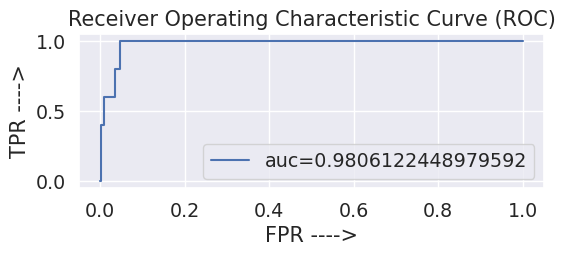

accuracy=  {0.7153652392947103} 

confusion_matrix=  [[279 113]
 [  0   5]] 

classification report= 
               precision    recall  f1-score   support

           0       1.00      0.71      0.83       392
           1       0.04      1.00      0.08         5

    accuracy                           0.72       397
   macro avg       0.52      0.86      0.46       397
weighted avg       0.99      0.72      0.82       397

f1 score =  0.0813008130081301


In [70]:
y=logistic_regression(xtrain_ss,xtest_ss,ytrain)
logreg_metrices=logistic_metrices(ytest,y[0])
end=time.time()

best_logreg_ss=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])

### Plotting ROC
plt.figure(figsize=(6,2))
plt.plot(fpr,tpr,label='auc='+str(auc_val))
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.xlabel("FPR ---->")
plt.ylabel("TPR ---->")
plt.legend(loc=4)
plt.show()

### Printing evaluation metrices
print(f'accuracy= ',{logreg_metrices[1]},'\n')
print(f'confusion_matrix= ',logreg_metrices[0],'\n')
print(f'classification report= \n',logreg_metrices[2])
print(f'f1 score = ',logreg_metrices[3])
time_taken=end-start

models_res.append(['Logistic regression - Standard Scaler',logreg_metrices[1],auc_val,logreg_metrices[3],time_taken,y[2]])

##### Logistic Regression Model Evaluation with MinMax Scaled features

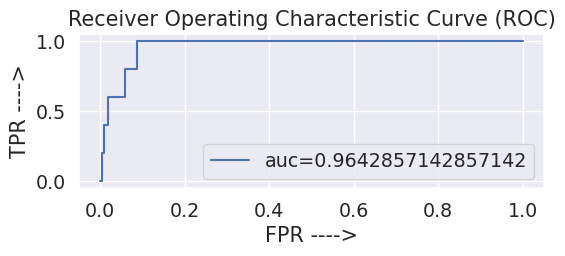

accuracy=  {0.7279596977329975} 

confusion_matrix= 
 [[284 108]
 [  0   5]] 

classification report= 
               precision    recall  f1-score   support

           0       1.00      0.72      0.84       392
           1       0.04      1.00      0.08         5

    accuracy                           0.73       397
   macro avg       0.52      0.86      0.46       397
weighted avg       0.99      0.73      0.83       397

f1 score =  0.0847457627118644


In [71]:
y=logistic_regression(xtrain_mm,xtest_mm,ytrain)

logreg_metrices=logistic_metrices(ytest,y[0])
end=time.time()

best_logreg_mm=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])

### Plotting ROC
plt.figure(figsize=(6,2))
plt.plot(fpr,tpr,label='auc='+str(auc_val))
plt.title("Receiver Operating Characteristic Curve (ROC)")
plt.xlabel("FPR ---->")
plt.ylabel("TPR ---->")
plt.legend(loc=4)
plt.show()

### Printing evalaution metrices
print(f'accuracy= ',{logreg_metrices[1]},'\n')
print(f'confusion_matrix= \n',logreg_metrices[0],'\n')
print(f'classification report= \n',logreg_metrices[2])
print(f'f1 score = ',logreg_metrices[3])
time_taken=end-start

models_res.append(['Logistic regression - MinMax Scaler',logreg_metrices[1],auc_val,logreg_metrices[3],time_taken,y[2]])

### Decision Tree Model

In [72]:
start=time.time()

from sklearn.tree import DecisionTreeClassifier

decitree=DecisionTreeClassifier()

## Hyper_parameter optimisation using Grid Search CV
def deci_tree_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 12],
        'min_samples_split':np.arange(3,11),
        'min_samples_leaf':np.arange(3,11),
        'max_leaf_nodes':np.arange(5,21)
        }
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=decitree, param_grid=param_grid, cv=5, verbose=0)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_    

def deci_tree(xtrain,xtest,ytrain):
    best_params = deci_tree_gridsearch(xtrain,ytrain)
    best_decitree = DecisionTreeClassifier(**best_params)
    best_decitree.fit(xtrain, ytrain)
    y_predict=best_decitree.predict(xtest)
    y_predictproba=best_decitree.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params,best_decitree]

def deci_tree_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

##### Decision Tree Model Evaluation with Standard Scaled features

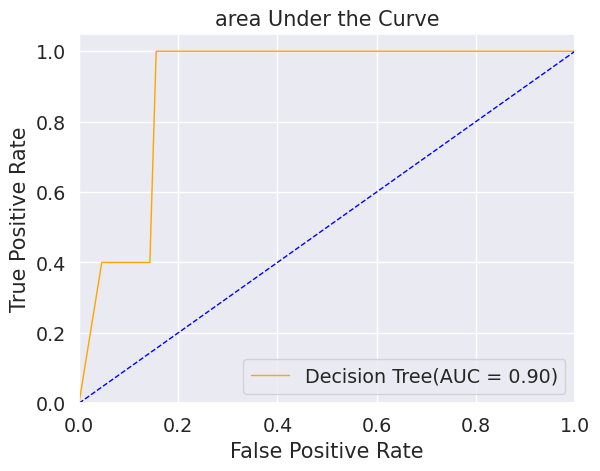

accuracy=  {0.8513853904282116} 

confusion_matrix= 
 [[336  56]
 [  3   2]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       392
           1       0.03      0.40      0.06         5

    accuracy                           0.85       397
   macro avg       0.51      0.63      0.49       397
weighted avg       0.98      0.85      0.91       397

f1 score =  0.0847457627118644


In [73]:
y=deci_tree(xtrain_ss,xtest_ss,ytrain)

decitree_metrices=deci_tree_metrices(ytest,y[0])
end=time.time()

best_decitree_ss=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Decision Tree(AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{decitree_metrices[1]},'\n')
print(f'confusion_matrix= \n',decitree_metrices[0],'\n')
print(f'classification report= \n',decitree_metrices[2])
print(f'f1 score = ',logreg_metrices[3])
time_taken=end-start

models_res.append(['Decision Tree - Standard Scaler',decitree_metrices[1],auc_val,decitree_metrices[3],time_taken,y[2]])

##### Decision Tree Model Evaluation with MinMax Scaled features

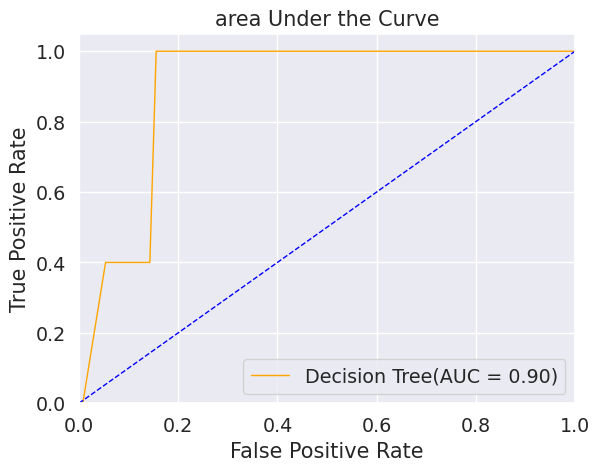

accuracy=  {0.8513853904282116} 

confusion_matrix= 
 [[336  56]
 [  3   2]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       392
           1       0.03      0.40      0.06         5

    accuracy                           0.85       397
   macro avg       0.51      0.63      0.49       397
weighted avg       0.98      0.85      0.91       397

f1 score =  0.0847457627118644


In [74]:
y=deci_tree(xtrain_mm,xtest_mm,ytrain)

decitree_metrices=deci_tree_metrices(ytest,y[0])
end=time.time()

best_decitree_mm=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Decision Tree(AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{decitree_metrices[1]},'\n')
print(f'confusion_matrix= \n',decitree_metrices[0],'\n')
print(f'classification report= \n',decitree_metrices[2])
print(f'f1 score = ',logreg_metrices[3])
time_taken=end-start

models_res.append(['Decision Tree - MinMax Scaler',decitree_metrices[1],auc_val,decitree_metrices[3],time_taken,y[2]])

### Random Forest Model

In [75]:
start=time.time()

from sklearn.ensemble import RandomForestClassifier

f1 = make_scorer(f1_score, average='macro')

randforest=RandomForestClassifier()

## Hyper_parameter optimisation using Grid Search CV
def rand_forest_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid={
        'max_depth':[4,5,6,7,8,9,10,11,12,13,14],
        'n_estimators':np.arange(50,500,100),
        'max_features':['auto','sqrt','log2',None],
        'criterion':['gini','entropy'],
        'min_samples_leaf':randint(1,4)
    }
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=randforest, param_grid=param_grid, cv=5, scoring=f1, verbose=0)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_    

def rand_forest(xtrain,xtest,ytrain):
    best_params = deci_tree_gridsearch(xtrain,ytrain)
    best_randforest = RandomForestClassifier(**best_params)
    best_randforest.fit(xtrain, ytrain)
    y_predict=best_randforest.predict(xtest)
    y_predictproba=best_randforest.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params,best_randforest]

def rand_forest_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

##### Random Forest Model Evaluation with Standard Scaled features

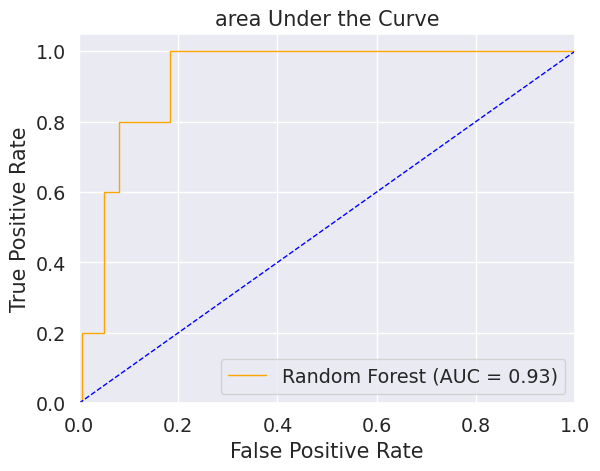

accuracy=  {0.906801007556675} 

confusion_matrix= 
 [[356  36]
 [  1   4]] 

classification report= 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       392
           1       0.10      0.80      0.18         5

    accuracy                           0.91       397
   macro avg       0.55      0.85      0.56       397
weighted avg       0.99      0.91      0.94       397

f1 score =  0.1777777777777778


In [76]:
y=rand_forest(xtrain_ss,xtest_ss,ytrain)

randforest_metrices=rand_forest_metrices(ytest,y[0])
end=time.time()

best_randforest_ss=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Random Forest (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{randforest_metrices[1]},'\n')
print(f'confusion_matrix= \n',randforest_metrices[0],'\n')
print(f'classification report= \n',randforest_metrices[2])
print(f'f1 score = ',randforest_metrices[3])
time_taken=end-start

models_res.append(['Random Forest - Standard Scaler',randforest_metrices[1],auc_val,randforest_metrices[3],time_taken,y[2]])

##### Random Forest Model Evaluation with MinMax Scaled features

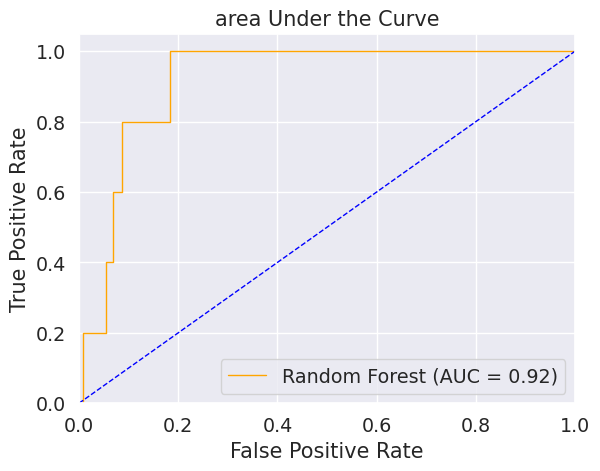

accuracy=  {0.9118387909319899} 

confusion_matrix= 
 [[358  34]
 [  1   4]] 

classification report= 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       392
           1       0.11      0.80      0.19         5

    accuracy                           0.91       397
   macro avg       0.55      0.86      0.57       397
weighted avg       0.99      0.91      0.94       397

f1 score =  0.18604651162790697


In [77]:
y=rand_forest(xtrain_mm,xtest_mm,ytrain)

randforest_metrices=rand_forest_metrices(ytest,y[0])
end=time.time()

best_randforest_mm=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Random Forest (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{randforest_metrices[1]},'\n')
print(f'confusion_matrix= \n',randforest_metrices[0],'\n')
print(f'classification report= \n',randforest_metrices[2])
print(f'f1 score = ',randforest_metrices[3])
time_taken=end-start

models_res.append(['Random Forest - MinMax Scaler',randforest_metrices[1],auc_val,randforest_metrices[3],time_taken,y[2]])

### ADABoost Model

In [78]:
start=time.time()

from sklearn.ensemble import AdaBoostClassifier

f1 = make_scorer(f1_score, average='macro')
adaboost=AdaBoostClassifier()

## Hyper_parameter optimisation using Grid Search CV
def ada_boost_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid={
        'n_estimators':np.arange(50,500,100),
        'learning_rate':[0.01,0.05,0.1,0.05,1]                
    }
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, scoring=f1, n_jobs=3, verbose=0,cv=5)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_    

def ada_boost(xtrain,xtest,ytrain):
    best_params = ada_boost_gridsearch(xtrain,ytrain)
    best_adaboost = AdaBoostClassifier(**best_params)
    #best_adaboost.set_params(base_estimator=DecisionTreeClassifier())
    best_adaboost.fit(xtrain, ytrain)
    y_predict=best_adaboost.predict(xtest)
    y_predictproba=best_adaboost.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params,best_adaboost]

def ada_boost_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

#### ADABoost model evaluation with Standard Scaled features

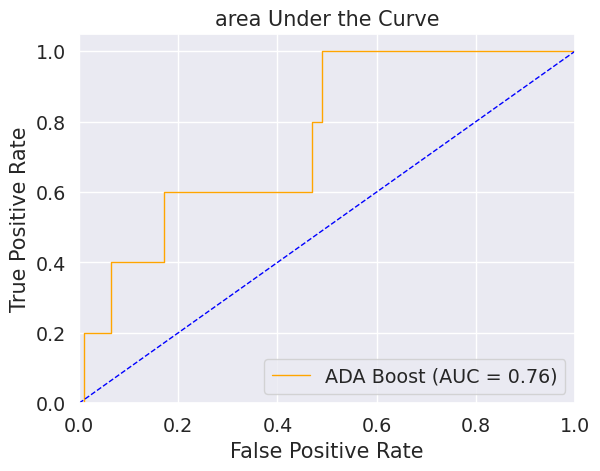

accuracy=  {0.9370277078085643} 

confusion_matrix= 
 [[371  21]
 [  4   1]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       392
           1       0.05      0.20      0.07         5

    accuracy                           0.94       397
   macro avg       0.52      0.57      0.52       397
weighted avg       0.98      0.94      0.96       397

f1 score =  0.07407407407407407


In [79]:
y=ada_boost(xtrain_ss,xtest_ss,ytrain)

adaboost_metrices=ada_boost_metrices(ytest,y[0])
end=time.time()

best_adaboost_ss=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='ADA Boost (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{adaboost_metrices[1]},'\n')
print(f'confusion_matrix= \n',adaboost_metrices[0],'\n')
print(f'classification report= \n',adaboost_metrices[2])
print(f'f1 score = ',adaboost_metrices[3])
time_taken=end-start

models_res.append(['ADA Boost - Standard Scaler',adaboost_metrices[1],auc_val,adaboost_metrices[3],time_taken,y[2]])

#### ADABoost model evaluation with MinMax Scaled features

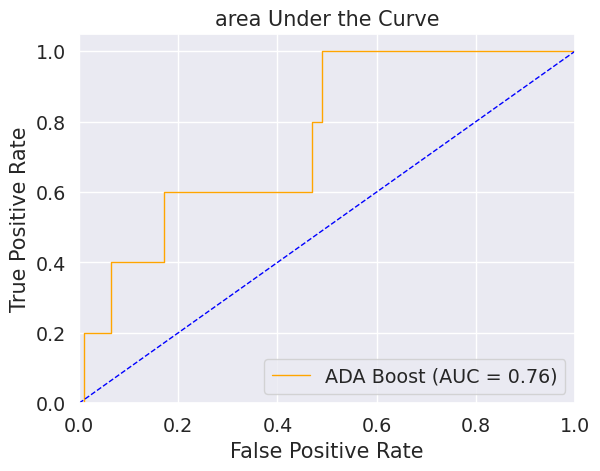

accuracy=  {0.9370277078085643} 

confusion_matrix= 
 [[371  21]
 [  4   1]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       392
           1       0.05      0.20      0.07         5

    accuracy                           0.94       397
   macro avg       0.52      0.57      0.52       397
weighted avg       0.98      0.94      0.96       397

f1 score =  0.07407407407407407


In [80]:
y=ada_boost(xtrain_mm,xtest_mm,ytrain)

adaboost_metrices=ada_boost_metrices(ytest,y[0])
end=time.time()

best_adaboost_mm=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='ADA Boost (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{adaboost_metrices[1]},'\n')
print(f'confusion_matrix= \n',adaboost_metrices[0],'\n')
print(f'classification report= \n',adaboost_metrices[2])
print(f'f1 score = ',adaboost_metrices[3])
time_taken=end-start

models_res.append(['ADA Boost - MinMax Scaler',adaboost_metrices[1],auc_val,adaboost_metrices[3],time_taken,y[2]])

### Gradient Boost Model

In [81]:
start=time.time()

from sklearn.ensemble import GradientBoostingClassifier

gradboost=GradientBoostingClassifier()
f1 = make_scorer(f1_score, average='macro')

## Hyper_parameter optimisation using Grid Search CV
def grad_boost_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 1, 0.5],
        'max_depth': [3, 4, 5],
        'min_samples_leaf': [4, 5, 6],
        'subsample': [0.6, 0.7, 0.8],
        'n_estimators': [5, 10, 15, 20]
    }
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=gradboost, param_grid=param_grid, scoring=f1, verbose=0,cv=5)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_    

def grad_boost(xtrain,xtest,ytrain):
    best_params = grad_boost_gridsearch(xtrain,ytrain)
    best_gradboost = GradientBoostingClassifier(**best_params)
    best_gradboost.fit(xtrain, ytrain)
    y_predict=best_gradboost.predict(xtest)
    y_predictproba=best_gradboost.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params,best_gradboost]

def grad_boost_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

#### Gradient Boost Model evaluation with Standard Scaled features

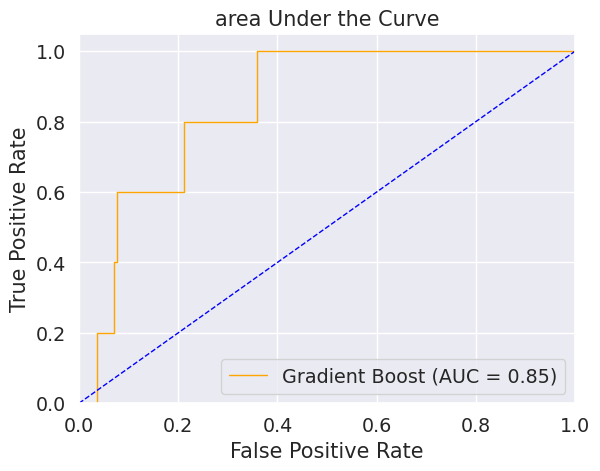

accuracy=  {0.9521410579345088} 

confusion_matrix= 
 [[378  14]
 [  5   0]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       392
           1       0.00      0.00      0.00         5

    accuracy                           0.95       397
   macro avg       0.49      0.48      0.49       397
weighted avg       0.97      0.95      0.96       397

f1 score =  0.0


In [82]:
y=grad_boost(xtrain_ss,xtest_ss,ytrain)

gradboost_metrices=grad_boost_metrices(ytest,y[0])
end=time.time()

best_gradboost_ss=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Gradient Boost (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{gradboost_metrices[1]},'\n')
print(f'confusion_matrix= \n',gradboost_metrices[0],'\n')
print(f'classification report= \n',gradboost_metrices[2])
print(f'f1 score = ',gradboost_metrices[3])
time_taken=end-start

models_res.append(['Gradient Boost - Standard Scaler',gradboost_metrices[1],auc_val,gradboost_metrices[3],time_taken,y[2]])

#### Gradient Boost Model evaluation with MinMax Scaled features 

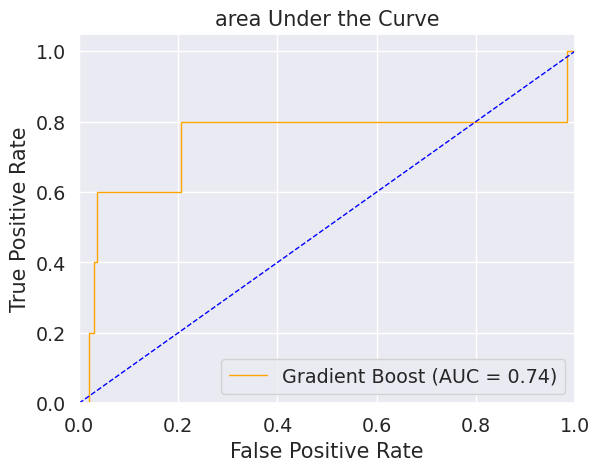

accuracy=  {0.9596977329974811} 

confusion_matrix= 
 [[380  12]
 [  4   1]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       392
           1       0.08      0.20      0.11         5

    accuracy                           0.96       397
   macro avg       0.53      0.58      0.55       397
weighted avg       0.98      0.96      0.97       397

f1 score =  0.1111111111111111


In [83]:
y=grad_boost(xtrain_mm,xtest_mm,ytrain)

gradboost_metrices=grad_boost_metrices(ytest,y[0])
end=time.time()

best_gradboost_mm=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Gradient Boost (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{gradboost_metrices[1]},'\n')
print(f'confusion_matrix= \n',gradboost_metrices[0],'\n')
print(f'classification report= \n',gradboost_metrices[2])
print(f'f1 score = ',gradboost_metrices[3])
time_taken=end-start

models_res.append(['Gradient Boost - MinMax Scaler',gradboost_metrices[1],auc_val,gradboost_metrices[3],time_taken,y[2]])

### K-Nearest Neighbours Model

In [84]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain_ss,ytrain)
y_pred_knn=knn.predict(xtest_ss)

In [85]:
class_report=classification_report(ytest,y_pred_knn)
print(class_report)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       392
           1       0.02      0.20      0.04         5

    accuracy                           0.88       397
   macro avg       0.51      0.55      0.49       397
weighted avg       0.98      0.88      0.93       397



#### Choose a value of K

In [86]:
acc_score=[]
start=time.time()

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,x_ss,y_copy,cv=10)
    acc_score.append(score.mean())

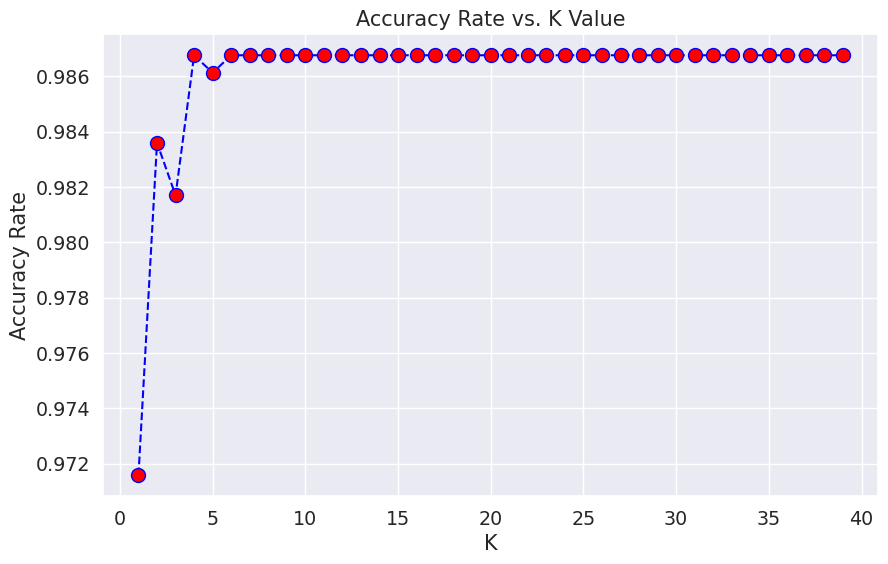

In [87]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc_score,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')
# plt.yticks(np.arange(.87,.94,.1))
plt.show()

In [88]:
# FROM THE ABOVE GRAPH THE OPTIMAL VALUE OF K CAN BE CHOSEN AS 6

# CHECKING THE MODEL FOR Manhattan  DISTANCE

knn_man=KNeighborsClassifier(n_neighbors=6,p=1)
knn.fit(xtrain_ss,ytrain)
y_pred_knn=knn.predict(xtest_ss)
y_pred_proba_k=knn.predict_proba(xtest_ss)[::,1]


acc_knn=accuracy_score(ytest,y_pred_knn)
f1_score_knn=f1_score(ytest,y_pred_knn)

tpr_k,fpr_k,_=roc_curve(ytest,y_pred_proba_k)
auc_k=auc(tpr_k,fpr_k)
print(confusion_matrix(ytest,y_pred_knn))

class_report=classification_report(ytest,y_pred_knn)
print(class_report)

print(f'f1 score = ',f1_score(ytest,y_pred_knn))

end=time.time()
time_taken=end-start

models_res.append(['KNN',acc_knn,auc_k,f1_score_knn,time_taken,{'Method':'Manhattan','K':6}])

[[273 119]
 [  2   3]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       392
           1       0.02      0.60      0.05         5

    accuracy                           0.70       397
   macro avg       0.51      0.65      0.43       397
weighted avg       0.98      0.70      0.81       397

f1 score =  0.04724409448818897


In [89]:
# CHECKING THE MODEL FOR Euclidean DISTANCE
from sklearn.metrics import auc
knn_euc=KNeighborsClassifier(n_neighbors=6,p=2)
knn.fit(xtrain_ss,ytrain)
y_pred_knn=knn.predict(xtest_ss)
y_pred_proba_k=knn.predict_proba(xtest_ss)[::,1]

acc_knn=accuracy_score(ytest,y_pred_knn)
f1_score_knn=f1_score(ytest,y_pred_knn)

tpr_k,fpr_k,_=roc_curve(ytest,y_pred_proba_k)
auc_k=auc(tpr_k,fpr_k)

print(confusion_matrix(ytest,y_pred_knn))

class_report=classification_report(ytest,y_pred_knn)
print(class_report)

f1_score_knn=f1_score(ytest,y_pred_knn)
print(f'f1 score = ',f1_score_knn)

models_res.append(['KNN',acc_knn,auc_k,f1_score_knn,time_taken,{'Method':'Eucledian','K':6}])

[[273 119]
 [  2   3]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       392
           1       0.02      0.60      0.05         5

    accuracy                           0.70       397
   macro avg       0.51      0.65      0.43       397
weighted avg       0.98      0.70      0.81       397

f1 score =  0.04724409448818897


### SVM Model

In [90]:
start=time.time()

from sklearn.svm import SVC

svm=SVC()

## Hyper_parameter optimisation using Grid Search CV
def svm_model_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf','poly','linear']}
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', verbose=0,cv=5)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_    

def svm_model(xtrain,xtest,ytrain):
    best_params = svm_model_gridsearch(xtrain,ytrain)
    best_svm = SVC(**best_params, probability=True)
    best_svm.fit(xtrain, ytrain)
    y_predict=best_svm.predict(xtest)
    y_predictproba=best_svm.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params,best_svm]

def svm_model_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

##### SVM model evaluation with Standard Scaled features

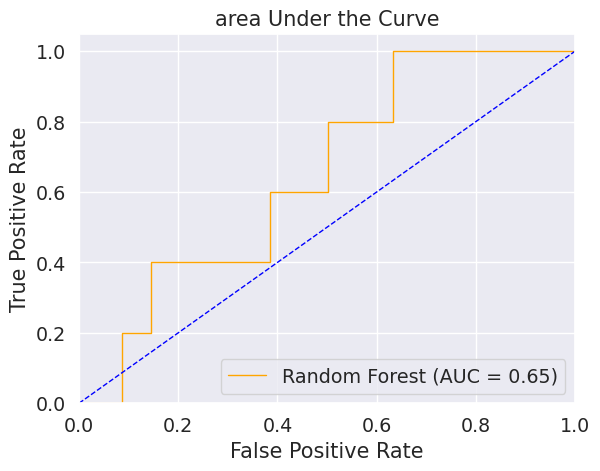

accuracy=  {0.7758186397984886} 

confusion_matrix= 
 [[306  86]
 [  3   2]] 

classification report= 
               precision    recall  f1-score   support

           0       0.99      0.78      0.87       392
           1       0.02      0.40      0.04         5

    accuracy                           0.78       397
   macro avg       0.51      0.59      0.46       397
weighted avg       0.98      0.78      0.86       397

f1 score =  0.043010752688172046


In [91]:
y=svm_model(xtrain_ss,xtest_ss,ytrain)

svm_metrices=svm_model_metrices(ytest,y[0])
end=time.time()

best_svm_ss=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Random Forest (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{svm_metrices[1]},'\n')
print(f'confusion_matrix= \n',svm_metrices[0],'\n')
print(f'classification report= \n',svm_metrices[2])
print(f'f1 score = ',svm_metrices[3])
time_taken=end-start

models_res.append(['SVM - MinMax Scaler',svm_metrices[1],auc_val,svm_metrices[3],time_taken,y[2]])

#### SVM model evaluation with MinMax Scaled features

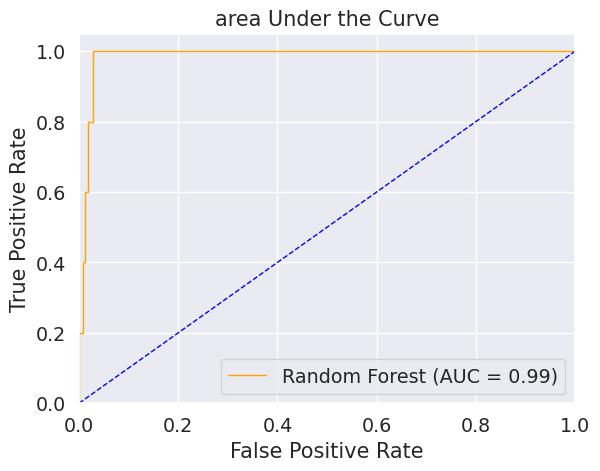

accuracy=  {0.7329974811083123} 

confusion_matrix= 
 [[286 106]
 [  0   5]] 

classification report= 
               precision    recall  f1-score   support

           0       1.00      0.73      0.84       392
           1       0.05      1.00      0.09         5

    accuracy                           0.73       397
   macro avg       0.52      0.86      0.46       397
weighted avg       0.99      0.73      0.83       397

f1 score =  0.08620689655172413


In [92]:
y=svm_model(xtrain_mm,xtest_mm,ytrain)

svm_metrices=svm_model_metrices(ytest,y[0])
end=time.time()

best_svm_mm=y[3]

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Random Forest (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{svm_metrices[1]},'\n')
print(f'confusion_matrix= \n',svm_metrices[0],'\n')
print(f'classification report= \n',svm_metrices[2])
print(f'f1 score = ',svm_metrices[3])
time_taken=end-start

models_res.append(['SVM - MinMax Scaler',svm_metrices[1],auc_val,svm_metrices[3],time_taken,y[2]])

### Summary of all the models performed above

In [93]:
models_summary=pd.DataFrame(models_res,columns=['Algorithm','Accuracy','AUC','F1 score','Time Taken(sec)','Best Hyper Parameters'])

In [94]:
pd.set_option('max_colwidth', None)
models_summary

,Algorithm,Accuracy,AUC,F1 score,Time Taken(sec),Best Hyper Parameters
0,Logistic regression - Standard Scaler,0.715365,0.980612,0.081301,0.346522,{'C': 0.001}
1,Logistic regression - MinMax Scaler,0.727960,0.964286,0.084746,1.071092,{'solver': 'liblinear'}
2,Decision Tree - Standard Scaler,0.851385,0.901276,0.063492,429.962499,"{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_samples_split': 4}"
3,Decision Tree - MinMax Scaler,0.851385,0.898214,0.063492,859.909865,"{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_samples_split': 4}"
4,Random Forest - Standard Scaler,0.906801,0.925510,0.177778,429.465198,"{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_samples_split': 3}"
5,Random Forest - MinMax Scaler,0.911839,0.919898,0.186047,858.575135,"{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_samples_split': 6}"
6,ADA Boost - Standard Scaler,0.937028,0.759184,0.074074,42.834769,"{'learning_rate': 1, 'n_estimators': 350}"
7,ADA Boost - MinMax Scaler,0.937028,0.759184,0.074074,85.294136,"{'learning_rate': 1, 'n_estimators': 350}"
8,Gradient Boost - Standard Scaler,0.952141,0.848980,0.000000,124.536513,"{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 20, 'subsample': 0.8}"
9,Gradient Boost - MinMax Scaler,0.959698,0.744388,0.111111,250.876758,"{'learning_rate': 1, 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 20, 'subsample': 0.8}"


In [95]:
models_summary.to_csv('output_rand10_SMOTE_tt1.csv', index=True)

### Summary

##### The target class has imbalanced data, which resulted 99% accuracy and 0 f1 score for all models
##### To improve the overall performance implemented Random over sampling method
##### Though F1 score was non-zero, almost all models were overfitting with >96% accuracy
##### Further to improve accuracy, unimplemented Random over sampling and implemented SMOTE method.

#### From the above table, it can be concluded that ADA Boost model with standard scaled features model performs well in terms of Accuracy, AUC and time taken for the travel type 1 of the given data, with ADA Boost model and Random Forest model with MinMax scaled features as alternatives.

##### ______________________________________________________________
##### Predict the entire feature data with the best model
##### --------------------------------------------------------------

In [100]:
prections_with_best_model = best_adaboost_ss.predict(x_ss)


In [105]:
np.set_printoptions(threshold=np.inf)
print(prections_with_best_model)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1
 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 